# One Port Tiered Calibration

## Intro

A one-port network analyzer can be used to measure a two-port device, provided that the device is reciprocal. This is accomplished by performing two calibrations, which is why its called a *tiered* calibration. 

First, the VNA is calibrated at the test-port like normal. This is called the *first tier*. Next, the device is connected to the test-port, and a calibration is performed at the far end of the device, the *second tier*. A diagram is shown below,

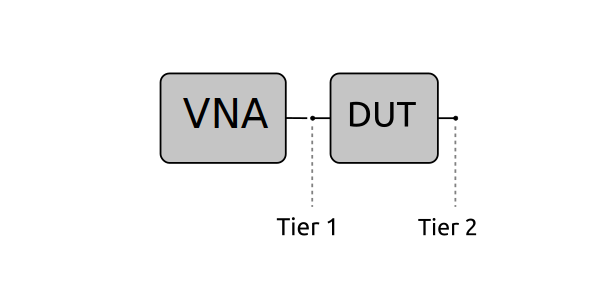

In [1]:
from IPython.display import SVG
SVG('oneport_tiered_calibration/images/boxDiagram.svg')

This notebook will demonstrate how to use [skrf](www.scikit-rf.org) to do a two-tiered one-port calibration.  We'll use  data that was taken to characterize a waveguide-to-CPW probe. So, for this specific example the diagram above looks like:

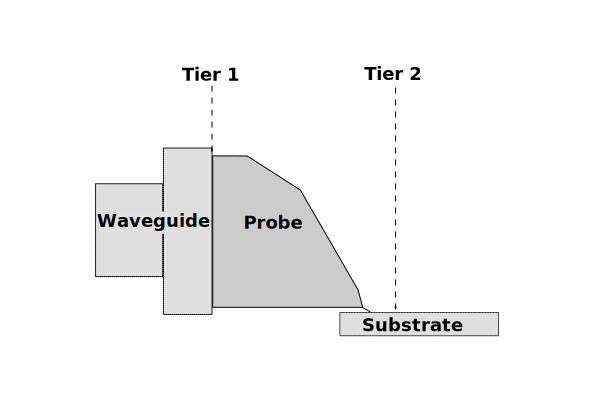

In [2]:
SVG('oneport_tiered_calibration/images/probe.svg')

## Some Data 

The data  available is the folders `'tier1/'` and `'tier2/'`. 

In [3]:
ls oneport_tiered_calibration/

images/  One Port Tiered Calibration.ipynb  probe.s2p  tier1/  tier2/


(if you dont have the git repo for these examples, the data for this notebook can be found [here](https://github.com/scikit-rf/examples/tree/master/oneport_tiered_calibration))

In each folder you will find the two sub-folders, called `'ideals/' ` and `'measured/'`. These contain touchstone files of the calibration standards ideal and measured responses,  respectively. 

In [4]:
ls oneport_tiered_calibration/tier1/

ideals/  measured/


The first tier is at waveguide interface, and consisted of the following set of standards

* short 
* delay short
* load
* radiating open (literally an open waveguide)

In [5]:
ls oneport_tiered_calibration/tier1/measured/

ds.s1p  load.s1p  ro.s1p  short.s1p


## Creating Calibrations

### Tier 1

First defining the calibration for *Tier 1*

In [6]:
from skrf.calibration import OnePort
import skrf as rf 

# enable in-notebook plots
%matplotlib inline
rf.stylely()

tier1_ideals = rf.read_all_networks('oneport_tiered_calibration/tier1/ideals/')
tier1_measured = rf.read_all_networks('oneport_tiered_calibration/tier1/measured/')
 

tier1 = OnePort(measured = tier1_measured,
                ideals = tier1_ideals,
                name = 'tier1',
                sloppy_input=True)
tier1

/home/alex/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


OnePort Calibration: 'tier1', 500-750 GHz, 401 pts, 4-standards

Because we saved corresponding *ideal* and *measured* standards with identical names, the Calibration will automatically align our standards upon initialization. (More info on creating Calibration objects this can be found in [the docs](http://scikit-rf.readthedocs.org/en/latest/tutorials/calibration.html).)

Similarly for the second tier 2,

### Tier 2

In [9]:
tier2_ideals = rf.read_all_networks('oneport_tiered_calibration/tier2/ideals/')
tier2_measured = rf.read_all_networks('oneport_tiered_calibration/tier2/measured/')
 

tier2 = OnePort(measured = tier2_measured,
                ideals = tier2_ideals,
                name = 'tier2',
                sloppy_input=True)
tier2

OnePort Calibration: 'tier2', 500-750 GHz, 401 pts, 5-standards

## Error Networks

Each one-port Calibration contains a two-port error network, that is determined from the calculated error coefficients. The error network for *tier1* models the VNA, while the error network for *tier2* represents the VNA **and** the DUT. These can be visualized through the parameter `'error_ntwk'`.


For tier 1, 

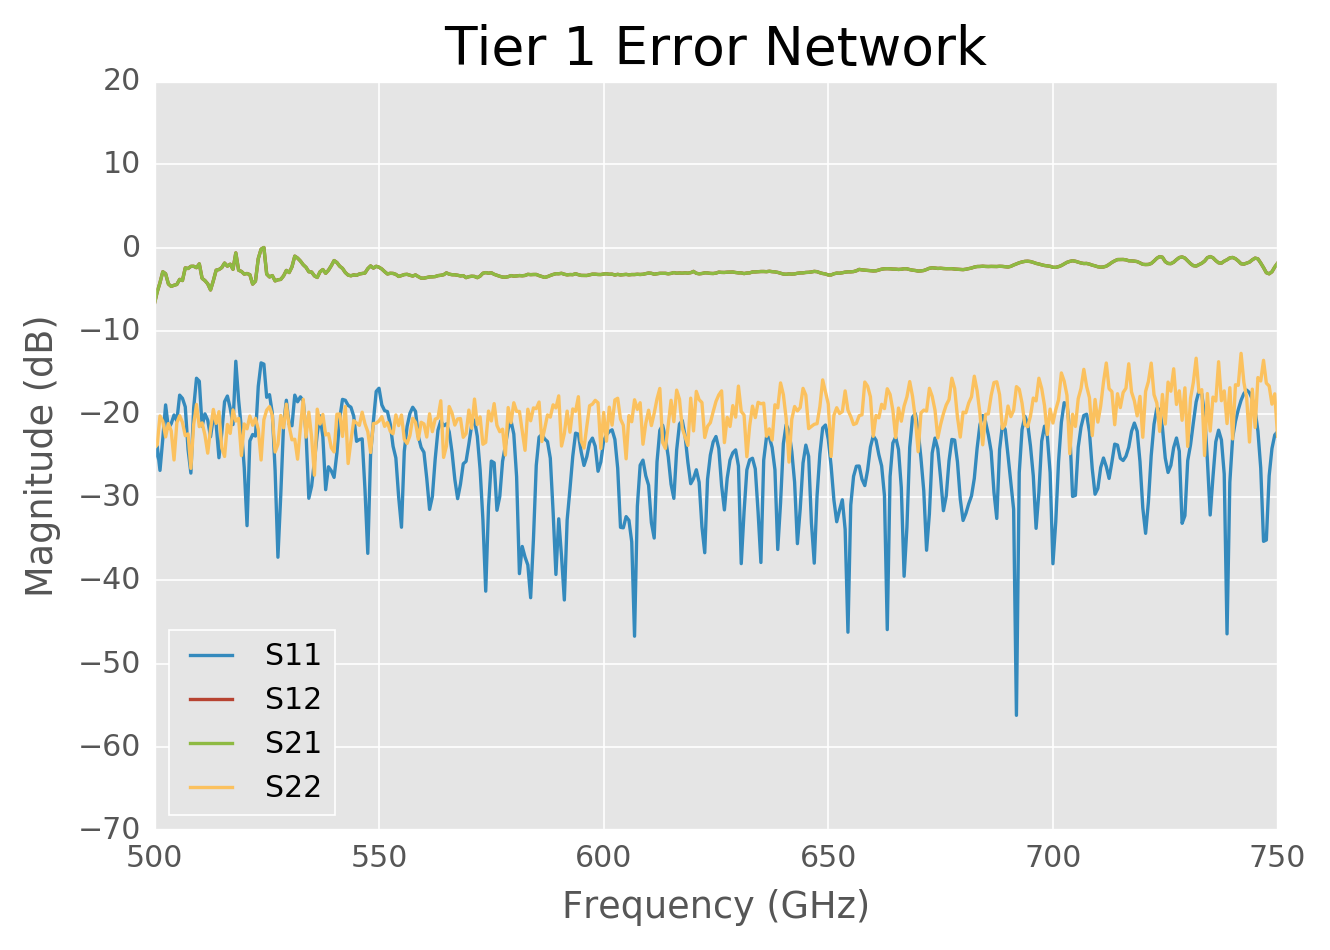

In [10]:
tier1.error_ntwk.plot_s_db()
title('Tier 1 Error Network')

Similarly for tier 2, 

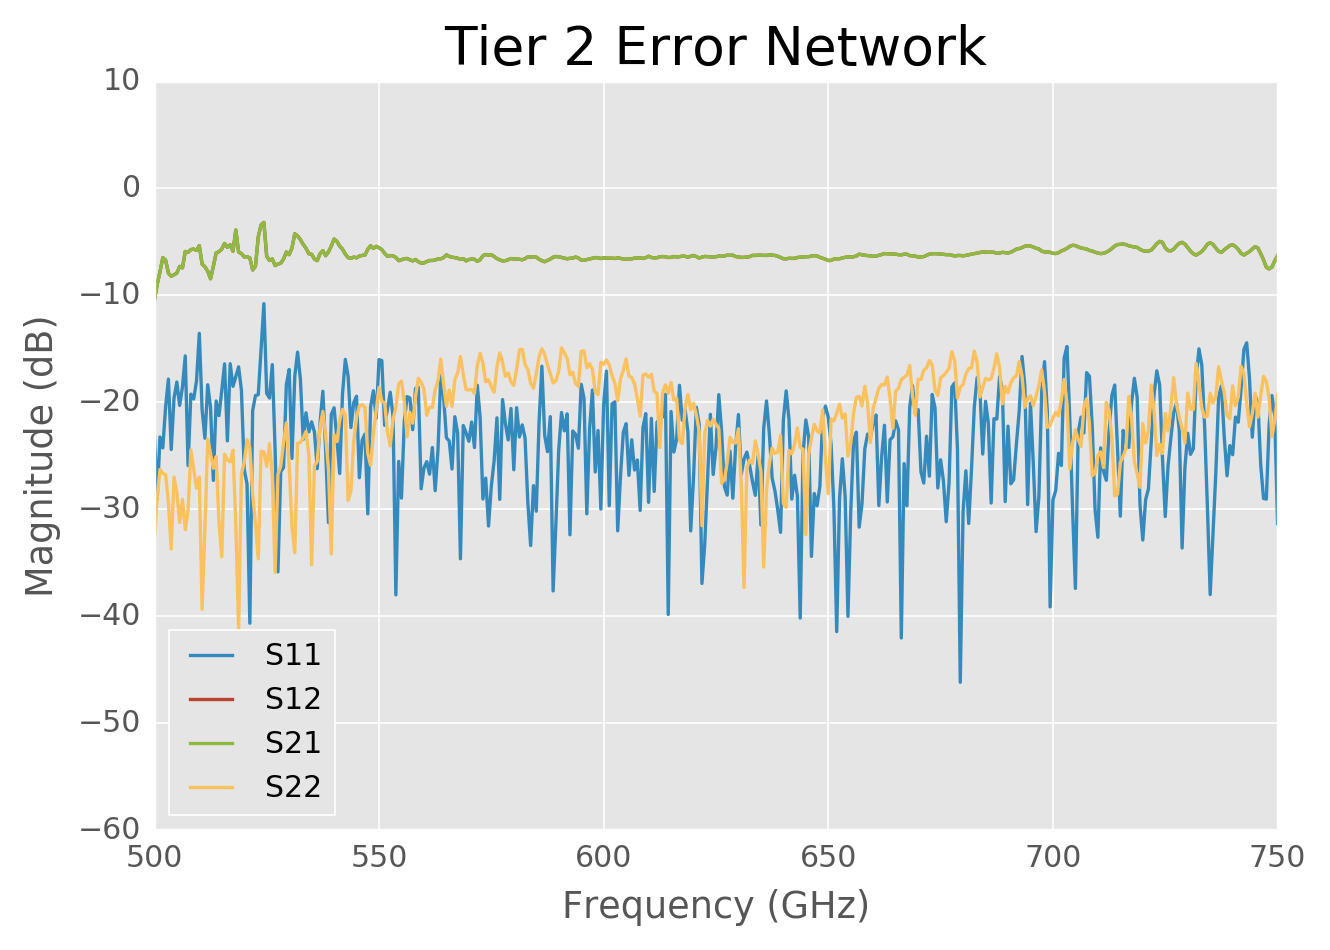

In [11]:
tier2.error_ntwk.plot_s_db()
title('Tier 2 Error Network')

## De-embedding the DUT

As previously stated, the error network for *tier1* models the VNA, and the error network for *tier2* represents the VNA+DUT. So to deterine the DUT's response, we cascade the inverse S-parameters of the VNA with the VNA+DUT. 

$$ DUT = VNA^{-1}\cdot (VNA \cdot DUT)$$

In skrf, this is done as follows

(-60, 10)

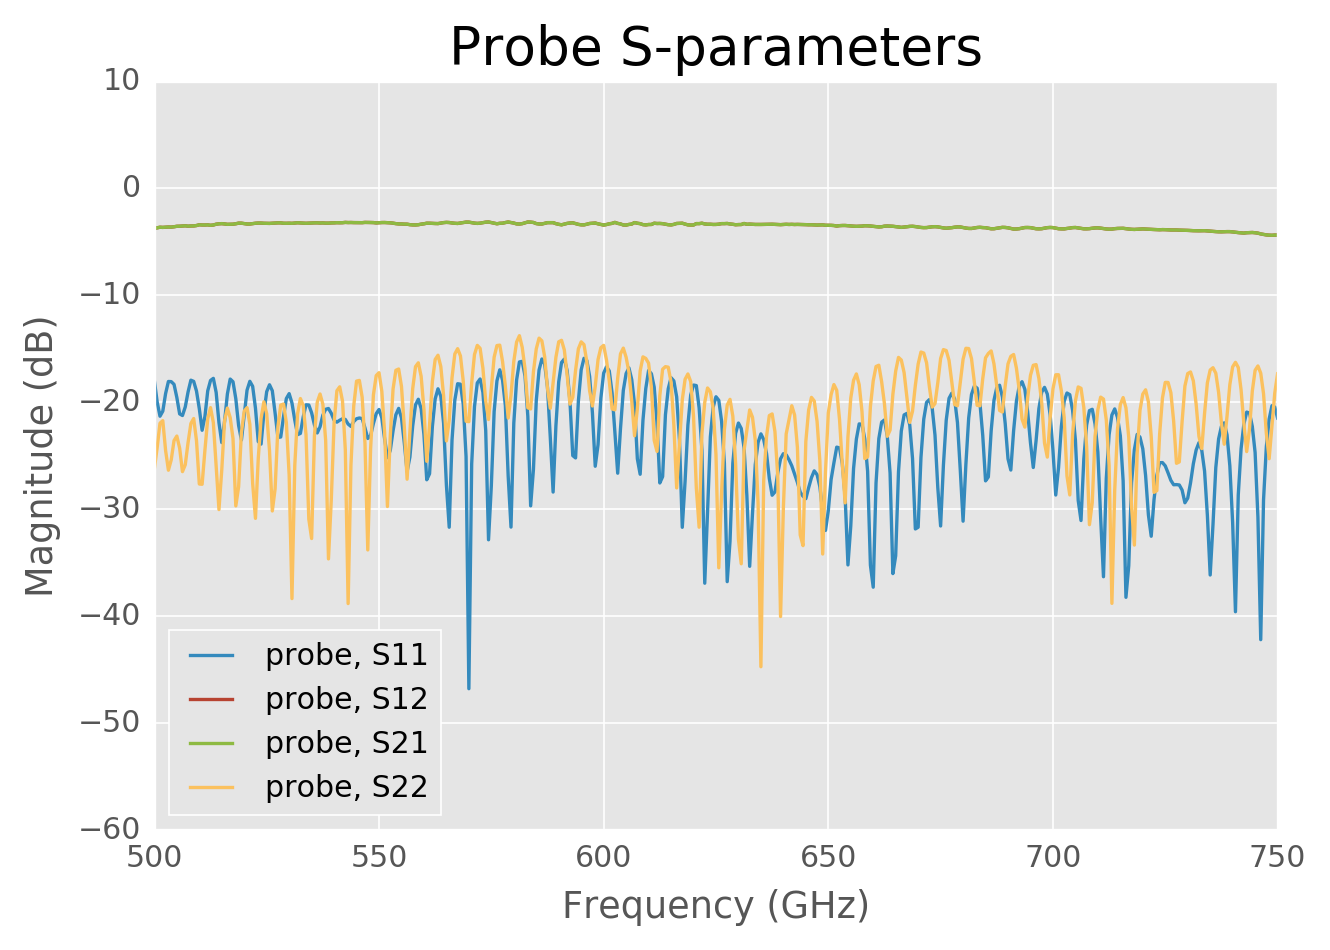

In [12]:
dut = tier1.error_ntwk.inv ** tier2.error_ntwk
dut.name = 'probe'
dut.plot_s_db()
title('Probe S-parameters')
ylim(-60,10)

You may want to save this to disk, for future use, 

In [13]:
dut.write_touchstone()

In [14]:
ls probe*

probe.s2p
